In [38]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import csv

In [39]:
# define month name in bahasa Malaysia
months_name = {
    1: 'januari',
    2: 'februari',
    3: 'mac',
    4: 'april',
    5: 'mei',
    6: 'jun',
    7: 'julai',
    8: 'ogos',
    9: 'september',
    10: 'oktober',
    11: 'november',
    12: 'disember'
}


In [40]:
def scrap_icu_case_date(day, month, year):
  URL = f"https://kpkesihatan.com/{year}/{month}/{day}/kenyataan-akhbar-kpk-{day}-{months_name[month]}-{year}-situasi-semasa-jangkitan-penyakit-coronavirus-2019-covid-19-di-malaysia"
  # get request
  response = requests.get(URL)
  if response.status_code == 200:
    html_text = response.text

     # scrap all tables
    soup = BeautifulSoup(html_text)
    tables = soup.findAll('table')

    death_outside_hospital = 0

    for table in tables:
      rows = table.findAll('tr')
      for row in rows:
        columns = row.findAll('td')
        for column in columns:
          # print(column.text)
          if 'Jenazah dibawa ke' in column.text:
            death_outside_hospital += 1

    li = soup.findAll('li')
    keyword = '(ICU)'
    keyword2 = 'pernafasan'
    keyword3 = 'kematian'
    for l in li:
      if keyword in l.text:
        date = f'{day}/{month}/{year}'

        _, keyword, data = l.text.partition(keyword)
        data = data.replace('\xa0',' ').split(' ')
        if len(data) == 3:
          icu_cases = data[1].replace(':','')
        else:
          icu_cases = data[2]

      if keyword2 in l.text:
        _, keyword2, data2 = l.text.partition(keyword2)
        data2 = data2.replace('\xa0',' ').split(' ')
        respiratory = data2[2]

      if keyword3 in l.text:
        _, keyword2, data2 = l.text.partition(keyword3)
        data3 = data2.replace('\xa0',' ').split(' ')
        dd = data3[1].split(':')[1]
        if dd == '':
          deaths = data3[2]
        else:
          deaths = dd
        return icu_cases, respiratory, deaths, death_outside_hospital
  else:
    print('Unable to connect to URL')

In [41]:
# starting day & month & year
start_day = 20
start_month = 1
start_year = 2021

# today's day & month & year
year = datetime.now().year
month = datetime.now().month
day = datetime.now().day

# generate datetime objects
sdate = datetime(start_year, start_month, start_day)   
edate = datetime(year, month, day)  

# generate date from start to end date
delta = edate - sdate
dates = []
cases = []
res = []
newdeaths = []
death_outside_hospital = []
for i in range(delta.days + 1):
    d = sdate + timedelta(days=i)

    icu_cases, respiratory, deaths, bid = scrap_icu_case_date(d.day, d.month,  d.year)
    if icu_cases is not None:
      if respiratory is not None:
        if deaths is not None:
          dates.append(f"{d.day}/{d.month}/{d.year}")
          cases.append(icu_cases)
          res.append(respiratory)
          newdeaths.append(deaths)
          death_outside_hospital.append(bid)
print(dates)
print(cases)
print(res)
print(newdeaths)
print(death_outside_hospital)

['20/1/2021', '21/1/2021', '22/1/2021', '23/1/2021', '24/1/2021', '25/1/2021', '26/1/2021', '27/1/2021', '28/1/2021', '29/1/2021', '30/1/2021', '31/1/2021', '1/2/2021', '2/2/2021', '3/2/2021', '4/2/2021', '5/2/2021', '6/2/2021', '7/2/2021', '8/2/2021', '9/2/2021', '10/2/2021', '11/2/2021', '12/2/2021', '13/2/2021', '14/2/2021', '15/2/2021', '16/2/2021', '17/2/2021', '18/2/2021', '19/2/2021', '20/2/2021', '21/2/2021', '22/2/2021', '23/2/2021', '24/2/2021', '25/2/2021', '26/2/2021', '27/2/2021', '28/2/2021', '1/3/2021', '2/3/2021', '3/3/2021', '4/3/2021', '5/3/2021', '6/3/2021', '7/3/2021', '8/3/2021', '9/3/2021', '10/3/2021', '11/3/2021', '12/3/2021', '13/3/2021', '14/3/2021', '15/3/2021', '16/3/2021', '17/3/2021', '18/3/2021', '19/3/2021', '20/3/2021', '21/3/2021', '22/3/2021', '23/3/2021', '24/3/2021', '25/3/2021', '26/3/2021', '27/3/2021', '28/3/2021', '29/3/2021', '30/3/2021', '31/3/2021', '1/4/2021', '2/4/2021', '3/4/2021', '4/4/2021', '5/4/2021', '6/4/2021', '7/4/2021', '8/4/2021'

In [42]:
with open('content/critical_data.csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['date', 'patient_in_icu', 'patient_on_ventilator_support', 'new_death_cases'])

    for i in range(len(dates)):
      writer.writerow([dates[i], cases[i], res[i], newdeaths[i]])


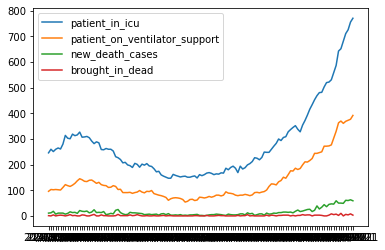

In [2]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Data
df=pd.read_csv('content/critical_data.csv')
 
# multiple line plots
plt.plot( 'date', 'patient_in_icu', data=df)
plt.plot( 'date', 'patient_on_ventilator_support', data=df)
plt.plot( 'date', 'new_death_cases', data=df)
plt.plot( 'date', 'brought_in_dead', data=df)


# show legend
plt.legend()

# show graph
plt.show()

In [15]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split

X = df[['patient_in_icu', 'patient_on_ventilator_support', 'brought_in_dead']]
y = df['new_death_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.9,random_state =0)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 45.96it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Ridge                                        0.91       0.91  4.28        0.01
ElasticNetCV                                 0.91       0.91  4.28        0.07
SGDRegressor                                 0.91       0.91  4.29        0.01
Lasso                                        0.90       0.91  4.35        0.01
LassoCV                                      0.90       0.90  4.40        0.05
RidgeCV                                      0.90       0.90  4.43        0.01
BayesianRidge                                0.90       0.90  4.44        0.02
OrthogonalMatchingPursuitCV                  0.90       0.90  4.49        0.01
LassoLarsCV                                  0.89       0.90  4.58        0.02
HuberRegressor                               0.89       0.89  4.67        0.05
ExtraTreesRegressor                          0.88   

In [16]:
from sklearn import linear_model
from sklearn.metrics import r2_score

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_pred_ls = regr.predict(X) 
print(r2_score(y, y_pred_ls))

0.9245613084169239


In [21]:
new_predictions = regr.predict([[1000, 500, 30]])
new_predictions

array([105.69176087])